# Conversion Funnel Analysis (CR Funnel)

https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/data

This project analyzes user behavior data from an e-commerce platform, using the publicly available dataset Ecommerce Behavior Data from Multi-category Store. The dataset contains approximately 67 million event logs from November 2019, capturing actions such as view, cart, and purchase, along with metadata like product category, brand, price, and user/session IDs.

The goal of this analysis is to construct and evaluate the conversion funnel, which tracks how users progress through different stages — from browsing products, to adding items to their cart, to completing purchases.

Conversion funnel analysis is an essential tool for companies because it highlights:
Where users drop off in the buying process.
Which segments or steps have the largest friction.
How user behavior varies by category, brand, time, and other dimensions.

By understanding these patterns, businesses can optimize the customer journey, improve user experience, and increase revenue through targeted interventions and experiments.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.0f}'.format)

In [42]:
import gc 
gc.collect()

0

In [4]:
df1 = pd.read_csv('ecommerce/2019-Nov.csv')
# df2 = pd.read_csv('ecommerce/2019-Oct.csv')

In [5]:
# df1 = df1.drop_duplicates()
# df1.shape
#67401460/67501979 => there was only 0.15% duplication - which wouldnt cause bias => 
    # i could check on the smaller portion to avoid big processing
df1.shape

(67501979, 9)

In [176]:
df1.event_time = pd.to_datetime(df1.event_time)
df1['weekday'] = df1.event_time.dt.weekday
df1['hour'] = df1.event_time.dt.hour
df1['day'] = df1.event_time.dt.day

In [177]:
df1.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,new_cat,weekday,hour,day
0,2019-11-01 00:00:00+00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2053013555631882655,4,0,1
1,2019-11-01 00:00:00+00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2053013566100866035,4,0,1
2,2019-11-01 00:00:01+00:00,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,2053013553853497655,4,0,1


In [34]:
#theres only three steps, too many categories and brands
df1.event_type.unique(), df1.brand.nunique(), df1.category_id.nunique()

(array(['view', 'cart', 'purchase'], dtype=object), 4200, 684)

In [10]:
#just checking the data structure 
df1[:10000].user_id.value_counts()

user_id
561564372    68
516853100    61
534949460    61
516316320    57
512483076    53
             ..
540182491     1
516736434     1
556869057     1
546183560     1
541970272     1
Name: count, Length: 2119, dtype: int64

In [12]:
df1[df1.user_id==561564372].user_session.nunique()

35

In [14]:
df1[df1.user_id==561564372].event_type.value_counts()

event_type
view        356
cart         14
purchase      6
Name: count, dtype: int64

In [22]:
funnel = df1.groupby('event_type').agg({'user_id':'nunique'}).reset_index()
funnel = funnel.sort_values('user_id', ascending=False).reset_index(drop=True)

In [30]:
funnel

,event_type,user_id
0,view,3695598
1,cart,826323
2,purchase,441638


In [31]:
funnel['CR'] = funnel.user_id / funnel.user_id.shift(1)

In [32]:
funnel

,event_type,user_id,CR
0,view,3695598,NaN
1,cart,826323,0.223597
2,purchase,441638,0.534462


In [41]:
categories = df1.groupby('category_id').agg({'user_id': 'count', 'category_code':'nunique'}).reset_index()

In [44]:
categories[categories.category_code>1]

,category_id,user_id,category_code


<Axes: >

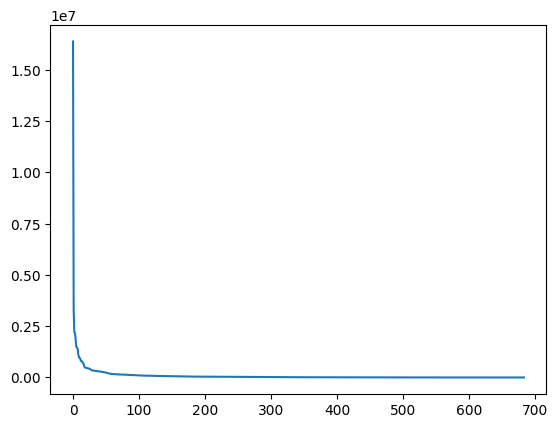

In [48]:
categories = categories.sort_values('user_id', ascending=False).reset_index()
categories.user_id.plot()

In [54]:
categories['new_cat'] = (categories.user_id>100000) * categories.category_id
df1 = df1.merge(categories[['category_id', 'new_cat']], on='category_id')

In [64]:
df1.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,new_cat
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2053013555631882655
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2053013566100866035
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,2053013553853497655


In [105]:
cat_funnel = df1.groupby(['event_type', 'new_cat']).agg({'user_id':'nunique'}).reset_index()
cat_funnel = cat_funnel.sort_values(['new_cat', 'user_id'], ascending=False).reset_index(drop=True)
cat_funnel['CR'] = cat_funnel.user_id / cat_funnel.user_id.shift(1)
cat_funnel = cat_funnel.pivot(index='new_cat', columns='event_type', values=['CR']).reset_index(drop=False)
cat_funnel.columns = ['new_cat', 'cart', 'purchase', 'view']
cat_funnel['view'] = np.nan

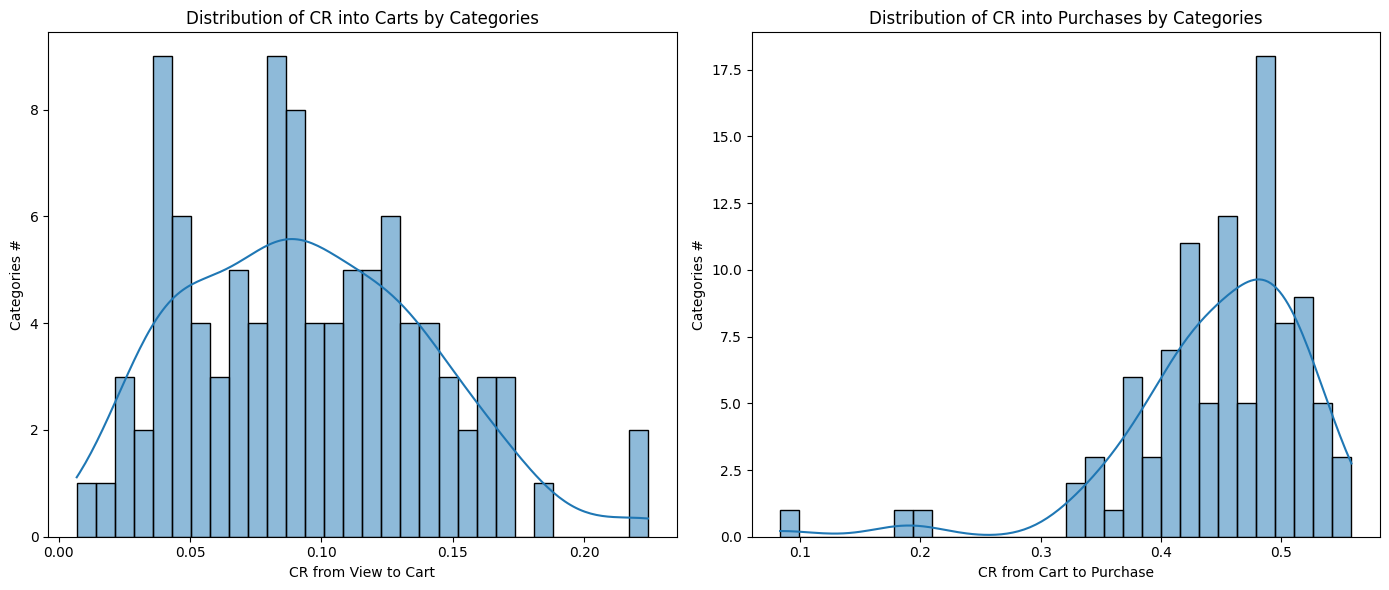

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cart histogram
sns.histplot(cat_funnel['cart'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of CR into Carts by Categories")
axes[0].set_xlabel("CR from View to Cart")
axes[0].set_ylabel("Categories #")

# Purchase histogram
sns.histplot(cat_funnel['purchase'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of CR into Purchases by Categories")
axes[1].set_xlabel("CR from Cart to Purchase")
axes[1].set_ylabel("Categories #")

plt.tight_layout()
plt.show()

#### Conversion rates vary significantly across different categories, indicating heterogeneous user behavior and potential opportunities to optimize underperforming segments.

In [96]:
cat_funnel[cat_funnel.purchase<0.3]

,new_cat,cart,purchase,view
8,2053013553115300101,0.028528,0.083558,NaN
14,2053013553526341921,0.086036,0.186401,NaN
92,2053013566562238479,0.050438,0.194836,NaN


In [199]:
df1[:100][df1[:100].category_id==2053013553115300101].head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,new_cat,weekday,hour,day
70,2019-11-01 00:00:24+00:00,view,10301494,2053013553115300101,NaN,welly,5.77,521368162,375da15e-023b-47a5-88f9-828c28637359,2053013553115300101,4,0,1


In [113]:
cat_price = df1.groupby(['new_cat']).agg({'price':['mean', 'median']}).reset_index()
cat_price.columns = ['new_cat', 'mean_price', 'median_price']
cat_funnel = cat_funnel.merge(cat_price, on='new_cat')

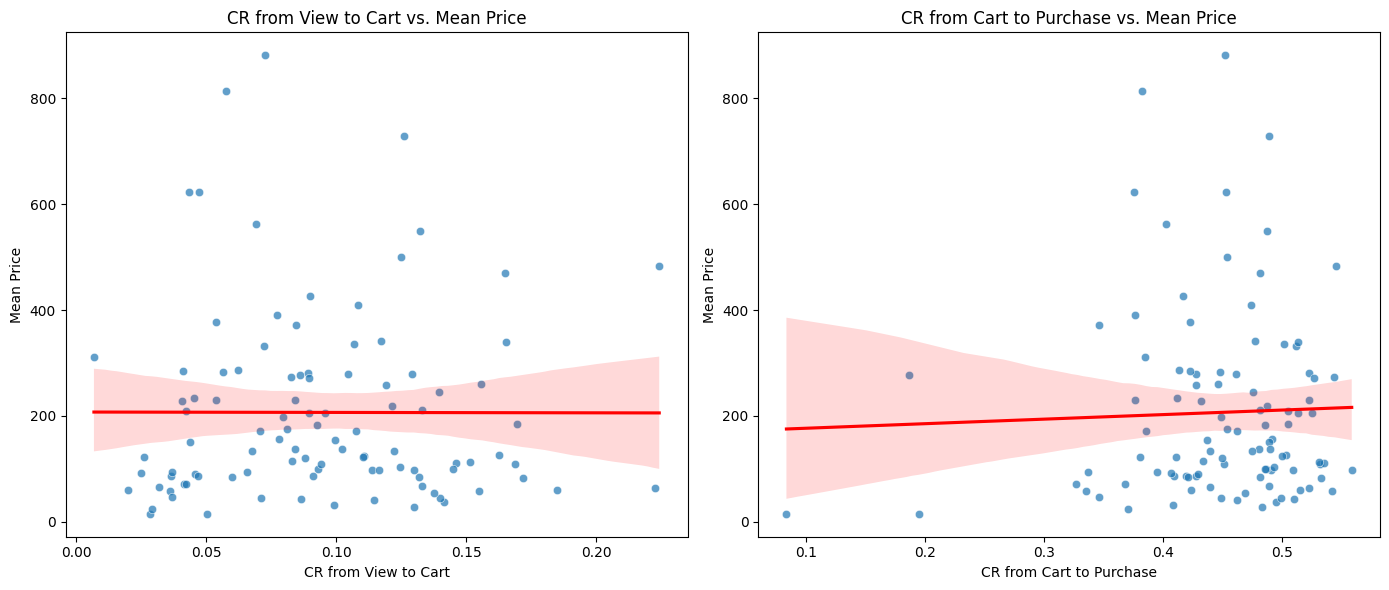

In [200]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=cat_funnel, x="cart", y="mean_price", ax=axes[0], alpha=0.7)
sns.regplot(data=cat_funnel, x="cart", y="mean_price", ax=axes[0], scatter=False, color="red")
axes[0].set_title("CR from View to Cart vs. Mean Price")
axes[0].set_xlabel("CR from View to Cart")
axes[0].set_ylabel("Mean Price")

sns.scatterplot(data=cat_funnel, x="purchase", y="mean_price", ax=axes[1], alpha=0.7)
sns.regplot(data=cat_funnel, x="purchase", y="mean_price", ax=axes[1], scatter=False, color="red")
axes[1].set_title("CR from Cart to Purchase vs. Mean Price")
axes[1].set_xlabel("CR from Cart to Purchase")
axes[1].set_ylabel("Mean Price")

plt.tight_layout()
plt.show()

#### There is no clear linear relationship between category mean price and conversion rates at either stage of the funnel. This suggests that price alone does not directly drive user behavior in progressing through the funnel.

In [ ]:
#parse weekday and hour 
#top brands
#price distribution or revenue over time
#purchase frequency distributios of users

In [151]:
weekday_funnel = df1.groupby(['weekday', 'event_type']).agg({'user_id': 'nunique', 'price':'sum'}).reset_index()
weekday_funnel = weekday_funnel.sort_values(['weekday', 'user_id'], ascending=False).reset_index(drop=True)
weekday_funnel['CR'] = weekday_funnel.user_id / weekday_funnel.user_id.shift(1)
weekday_funnel = weekday_funnel.pivot(index='weekday', columns='event_type', values=['CR', 'price', 'user_id']).reset_index(drop=False)
weekday_funnel.columns = ['new_cat', 'cart', 'purchase', 'view', 'users_cart', 'users_purchase', 'users_view', 
                          'price_cart', 'price_purchase', 'price_view']
weekday_funnel['view'] = np.nan

In [152]:
weekday_funnel

,new_cat,cart,purchase,view,users_cart,users_purchase,users_view,price_cart,price_purchase,price_view
0,0,0.120874,0.596058,NaN,6.430214e+07,30593833.33,2.039631e+09,117866.0,70255.0,975118.0
1,1,0.117514,0.588106,NaN,6.020093e+07,28215647.66,1.933795e+09,110203.0,64811.0,937788.0
2,2,0.117328,0.588569,NaN,6.054439e+07,28461191.93,1.924538e+09,110485.0,65028.0,941675.0
3,3,0.142338,0.470915,NaN,1.024253e+08,28145802.06,2.292585e+09,137908.0,64943.0,968874.0
4,4,0.232392,0.262803,NaN,2.188849e+08,31317606.39,3.588757e+09,268585.0,70585.0,1155740.0
5,5,0.205717,0.431320,NaN,1.835151e+08,50923371.24,3.691100e+09,249979.0,107821.0,1215157.0
6,6,0.213947,0.697136,NaN,1.610066e+08,77535628.20,3.117229e+09,224239.0,156325.0,1048103.0


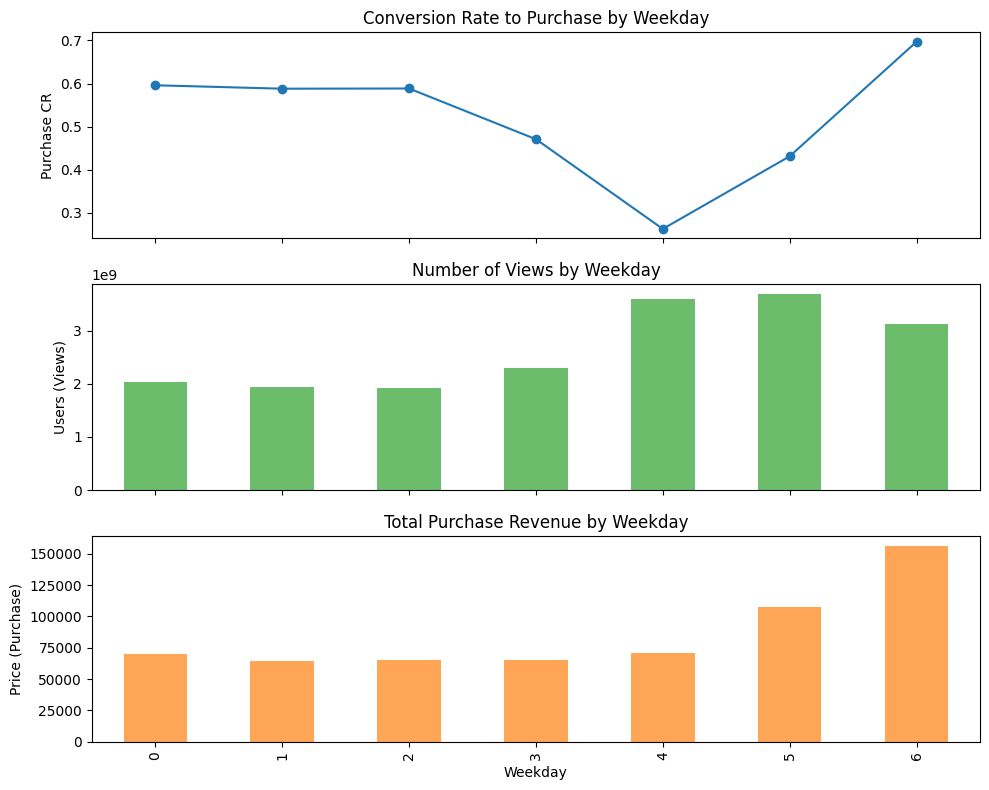

In [202]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

weekday_funnel['purchase'].plot(ax=axes[0], marker='o', color='tab:blue')
axes[0].set_title("Conversion Rate to Purchase by Weekday")
axes[0].set_ylabel("Purchase CR")

weekday_funnel['users_view'].plot.bar(ax=axes[1], color='tab:green', alpha=0.7)
axes[1].set_title("Number of Views by Weekday")
axes[1].set_ylabel("Users (Views)")

weekday_funnel['price_purchase'].plot.bar(ax=axes[2], color='tab:orange', alpha=0.7)
axes[2].set_title("Total Purchase Revenue by Weekday")
axes[2].set_ylabel("Price (Purchase)")
axes[2].set_xlabel("Weekday")

plt.tight_layout()
plt.show()


#### User engagement (views) increases noticeably from Friday through Sunday, indicating higher browsing activity heading into the weekend. However, the conversion rate to purchase is lowest on Friday despite high traffic, suggesting that users are in the exploration phase at the start of the weekend and take additional time to decide. The highest total revenue and highest conversion rates are observed on Sunday, indicating that users return with a firm intent to purchase toward the end of the weekend.

In [203]:
hour_funnel = df1.groupby(['hour', 'event_type']).agg({'user_id': 'nunique', 'price':'sum'}).reset_index()
hour_funnel = hour_funnel.sort_values(['hour', 'user_id'], ascending=False).reset_index(drop=True)
hour_funnel['CR'] = hour_funnel.user_id / hour_funnel.user_id.shift(1)
hour_funnel = hour_funnel.pivot(index='hour', columns='event_type', values=['CR', 'price', 'user_id']).reset_index(drop=False)
hour_funnel.columns = ['new_cat', 'cart', 'purchase', 'view', 'users_cart', 'users_purchase', 'users_view', 
                          'price_cart', 'price_purchase', 'price_view']
hour_funnel['view'] = np.nan

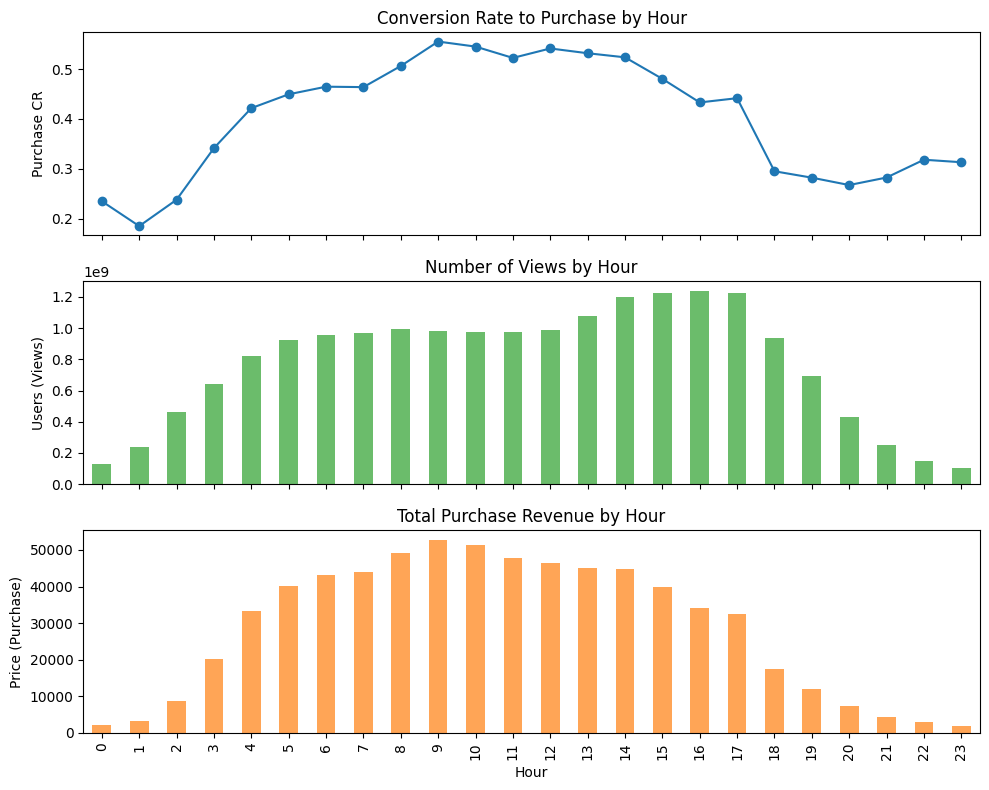

In [204]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

hour_funnel['purchase'].plot(ax=axes[0], marker='o', color='tab:blue')
axes[0].set_title("Conversion Rate to Purchase by Hour")
axes[0].set_ylabel("Purchase CR")

hour_funnel['users_view'].plot.bar(ax=axes[1], color='tab:green', alpha=0.7)
axes[1].set_title("Number of Views by Hour")
axes[1].set_ylabel("Users (Views)")

hour_funnel['price_purchase'].plot.bar(ax=axes[2], color='tab:orange', alpha=0.7)
axes[2].set_title("Total Purchase Revenue by Hour")
axes[2].set_ylabel("Price (Purchase)")
axes[2].set_xlabel("Hour")

plt.tight_layout()
plt.show()


#### User traffic peaks midday, but conversion rates and revenue are highest earlier, around 9–12 AM, suggesting early shoppers are more decisive and valuable. Engagement remains high later but with lower conversion.

In [205]:
day_funnel = df1.groupby(['day', 'event_type']).agg({'user_id': 'nunique', 'price':'sum'}).reset_index()
day_funnel = day_funnel.sort_values(['day', 'user_id'], ascending=False).reset_index(drop=True)
day_funnel['CR'] = day_funnel.user_id / day_funnel.user_id.shift(1)
day_funnel = day_funnel.pivot(index='day', columns='event_type', values=['CR', 'price', 'user_id']).reset_index(drop=False)
day_funnel.columns = ['new_cat', 'cart', 'purchase', 'view', 'users_cart', 'users_purchase', 'users_view', 
                          'price_cart', 'price_purchase', 'price_view']
day_funnel['view'] = np.nan

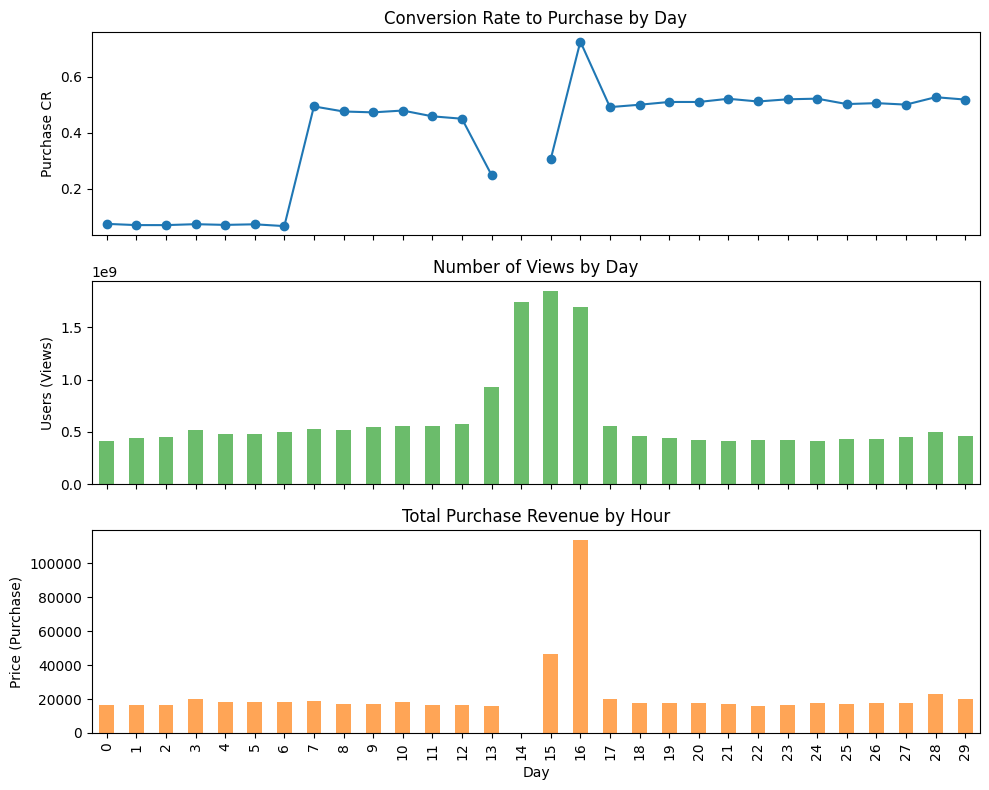

In [206]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

day_funnel['purchase'].plot(ax=axes[0], marker='o', color='tab:blue')
axes[0].set_title("Conversion Rate to Purchase by Day")
axes[0].set_ylabel("Purchase CR")

day_funnel['users_view'].plot.bar(ax=axes[1], color='tab:green', alpha=0.7)
axes[1].set_title("Number of Views by Day")
axes[1].set_ylabel("Users (Views)")

day_funnel['price_purchase'].plot.bar(ax=axes[2], color='tab:orange', alpha=0.7)
axes[2].set_title("Total Purchase Revenue by Hour")
axes[2].set_ylabel("Price (Purchase)")
axes[2].set_xlabel("Day")

plt.tight_layout()
plt.show()


In [231]:
df1[(df1.day==15) & (df1.event_type=='purchase')].user_id.nunique()

0

#### The data exhibits clear anomalies, with disproportionately high traffic, conversion rates, and revenue concentrated around days 14–16. Prior to this, both conversion rate and volume appear unusually low. This pattern suggests either a logging issue in the first week, a batch update or backfill of data mid-month, or an extraordinary one-off event (such as a campaign or anomaly). Further investigation is required to validate data integrity and understand the true underlying behavior.

In [215]:
#checking the code is valid
# explore = df1.groupby(['day', 'event_type']).agg({'user_id': 'nunique', 'price':'sum'}).reset_index()
# explore = explore.pivot(index='day', columns='event_type', values=['price', 'user_id']).reset_index(drop=False)
# explore.columns = ['day', 'price_cart', 'price_purchase', 'price_view', 'users_cart', 'users_purchase', 'users_view']
# explore['CR_view_cart'] = explore.users_cart / explore.users_view
# explore['CR_cart_purchase'] = explore.users_purchase / explore.users_cart
# explore['CR_view_purchase'] = explore.users_purchase / explore.users_view

In [162]:
popular_brands = df1.value_counts('brand')[:10]
popular_categories = df1.fillna('Unknown').value_counts('category_code')[:10] #here its better avoid fillna for computational preservation
popular_products = df1.value_counts('product_id')[:10]
df_part = df1[:3000]
df_part = df_part[df_part.product_id.isin(popular_products.index)].reset_index().drop_duplicates('product_id').price

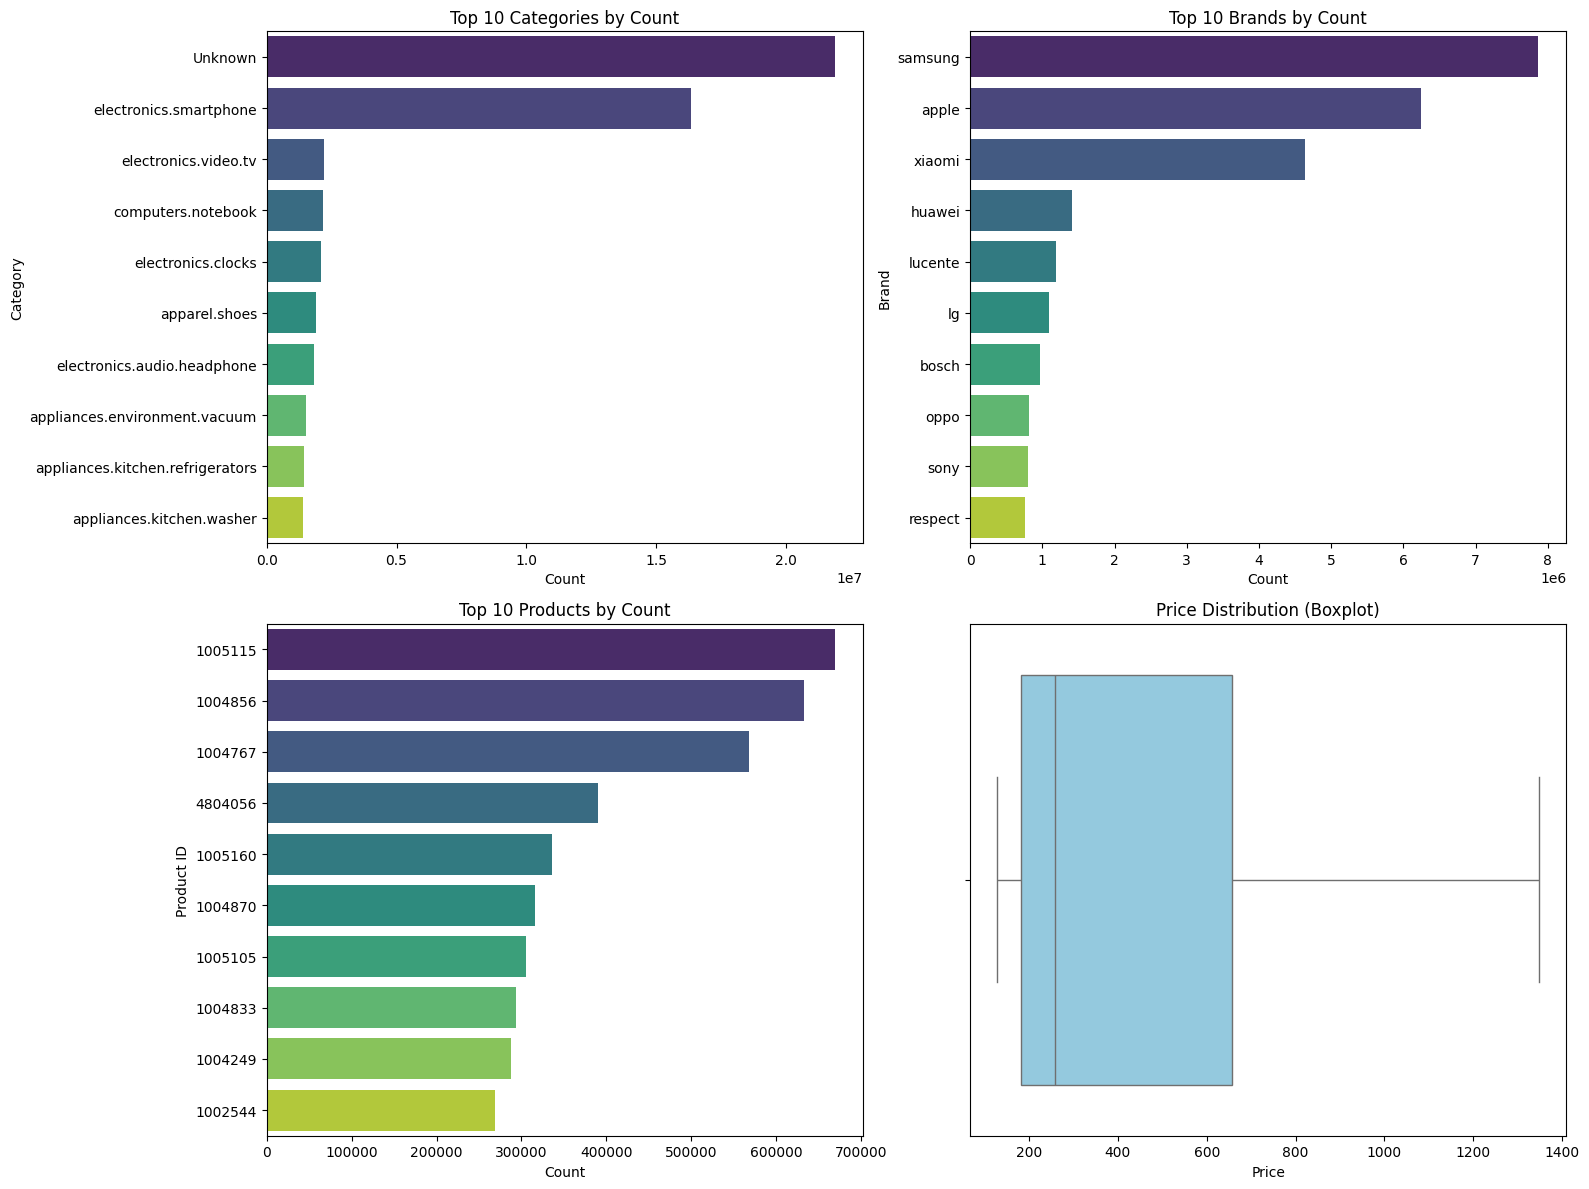

In [249]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(
    x=popular_categories.values,
    y=popular_categories.index,
    ax=axes[0, 0],
    palette="viridis"
)
axes[0, 0].set_title("Top 10 Categories by Count")
axes[0, 0].set_xlabel("Count")
axes[0, 0].set_ylabel("Category")

sns.barplot(
    x=popular_brands.values,
    y=popular_brands.index,
    ax=axes[0, 1],
    palette="viridis"
)
axes[0, 1].set_title("Top 10 Brands by Count")
axes[0, 1].set_xlabel("Count")
axes[0, 1].set_ylabel("Brand")

sns.barplot(
    x=popular_products.values,
    y=popular_products.index.astype(str),
    ax=axes[1, 0],
    palette="viridis"
)
axes[1, 0].set_title("Top 10 Products by Count")
axes[1, 0].set_xlabel("Count")
axes[1, 0].set_ylabel("Product ID")

sns.boxplot(
    x=df_part,
    ax=axes[1, 1],
    color="skyblue"
)
axes[1, 1].set_title("Price Distribution (Boxplot)")
axes[1, 1].set_xlabel("Price")

plt.tight_layout()
plt.show()


#### User engagement is heavily concentrated in the electronics segment, with smartphones, TVs, and notebooks dominating the top categories and brands like Samsung, Apple, and Xiaomi leading in popularity. The most interacted-with products are also aligned with these categories, though demand is more evenly spread at the product level, reflecting diverse consumer choices. Price distribution shows that most purchases cluster in the mid-range 200–600 dollars.

In [180]:
loyal_users = df1[df1.event_type=='purchase'][['event_time', 'user_id']].groupby('user_id').count().reset_index()

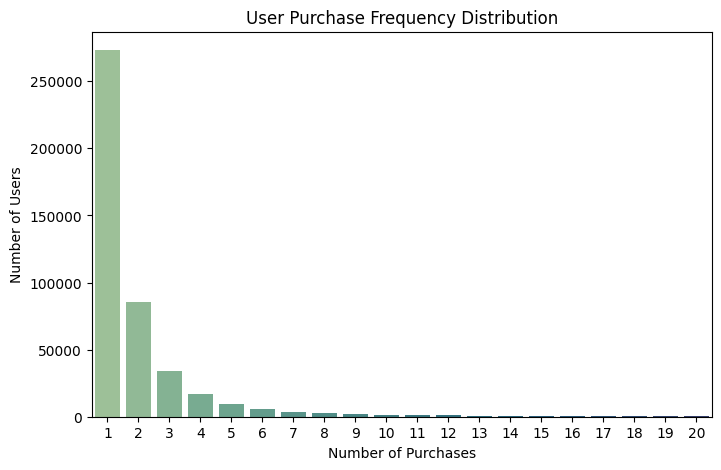

In [248]:
plt.figure(figsize=(8, 5))

user_freq = loyal_users['event_time'].value_counts().sort_index()[:20]
sns.barplot(
    x=user_freq.index,
    y=user_freq.values,
    palette="crest"
)

plt.title("User Purchase Frequency Distribution")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Users")
plt.show()

#### The vast majority of users (over 250,000) made only a single purchase, while the number of repeat buyers declines sharply with each additional purchase. This shows a highly skewed distribution, highlighting a potential opportunity to improve retention and encourage repeat purchases.

# SUMMARY

Recommendations from Funnel Analysis:  

Fix data gaps in the category column to ensure accurate attribution of user actions.  
Audit and resolve mid-month data anomalies to improve reliability of insights.  
Start collecting platform and device data for better segmentation and targeting.  
Focus promotions and inventory on electronics smartphones, TVs, and notebooks, which drive the highest engagement.  
Retarget Friday visitors with weekend-specific promotions to reduce drop-off.  
Schedule campaigns and limited-time offers on Sundays to capitalize on high conversion intent.  
Run morning flash sales or discounts to capture the more decisive early-day shoppers.  
Analyze a longer time period to measure user retention and design loyalty programs or incentives to convert single-purchase users into repeat buyers.